In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import function_library_assignment_1 as fnc

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

In [7]:
n_bus = 24
S_base_3ph = 100
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')
gen_costs = fnc.read_data('gen_costs')
line_data = fnc.read_data('line_data')
branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data')

In [3]:
gens_map, wf_map = fnc.mapping_dictionaries(gen_data)

gens_map.get(14) #example: get the generator indices at bus 14 (15 in the assignment formulation)

[4, 5]

# Task 3 - Multi-Step OPF

In [4]:
bess_nodes = np.array([2,4,6]) #wind farms with BESS: WF1, WF2 and WF3 - note the nodes here are 0-indexed

bess_map = {}

for n in range(n_bus):
    bess_map[n] = np.where(bess_nodes == n)[0].tolist()

#sanity check
bess_map.get(6)

[2]

In [14]:
n_hours = 24
# Define input parameters of batteries

SOC_max = 450 / S_base_3ph # Maximum SOC capacity 
SOC_ini = 200 / S_base_3ph # initial SOC at start
p_BESS = 150 / S_base_3ph # Dis-/charging capacity
eta_chg = 0.9 # charging efficiency
eta_dischg = 1.1 # discharging efficiency

def plot_multihour(results, BESS: bool = True, save_fig: bool = False):

    if BESS:
        fig, ax = plt.subplots(2,1,sharex=True,figsize=( 12 , 6 ) , dpi=300, gridspec_kw={'height_ratios': [2, 1]}) # Create the figure

        ax[0].step(results.get('overview').index, results.get('overview')['Load [MW]'], where='post', color='black', label='Load', linestyle='--')
        ax[0].stackplot(results.get('overview').index, results.get('overview')[['Wind [MW]', 'Dispatchable Production [MW]', 'BESS Discharging [MW]']].T, 
                    step='post', edgecolor='dimgrey', labels=['Wind', 'Dispatchable Generation', 'BESS Discharging'], colors=['tab:blue', 'tab:orange', 'tab:green'])
        ax[0].stackplot(results.get('overview').index, -1 * results.get('overview')['BESS Charging [MW]'].T, step='post', edgecolor='dimgrey', labels=['BESS Charging'], linewidth=0.6, colors=['tab:red'])
        ax[0].axhline(0, color='black', linewidth=1.2, linestyle=':')


        ax[0].set_ylabel('Power [MW]')
        ax[0].legend(loc='upper left', bbox_to_anchor=(-0.006, 1.15),ncol=5, fontsize=10)
        ax[1].plot(results.get('overview').index, results.get('overview')['BESS_1 SOC [%]'], linestyle=':', color='saddlebrown', linewidth=1.2)
        ax[1].plot(results.get('overview').index, results.get('overview')['BESS_1 SOC [%]'], label='BESS 1', linestyle='', marker='o', markersize=4, color='saddlebrown')
        ax[1].plot(results.get('overview').index, results.get('overview')['BESS_2 SOC [%]'], linestyle=':', color='darkslategrey', linewidth=1.2)
        ax[1].plot(results.get('overview').index, results.get('overview')['BESS_2 SOC [%]'], label='BESS 2', linestyle='', marker='o', markersize=4, color='darkslategrey')
        ax[1].plot(results.get('overview').index, results.get('overview')['BESS_3 SOC [%]'], linestyle=':', color='indigo', linewidth=1.2)
        ax[1].plot(results.get('overview').index, results.get('overview')['BESS_3 SOC [%]'], label='BESS 3', linestyle='', marker='o', markersize=4, color='indigo')
        ax[1].legend(loc='lower left', ncol=3, fontsize=10, markerscale=1.5)
        ax[1].set_ylabel('SOC [%]')

        ax[1].margins(x=0)
        ax[1].set_ylim([0,105])
        ax[1].set_xticks(np.arange(0,24))
        ax[1].set_xticklabels(np.arange(1,25))
        ax[1].set_xlabel('Hour')
        ax[0].set_axisbelow(True)
        ax[1].set_axisbelow(True)

        #plt.suptitle('Objective Value: %.1f DKK\nTotal Load: %.1f MWh\nTotal Production: %.1f MWh\n(Wind: %.1f MWh & Generators: %.1f MWh)' % (m.objVal, sum_load, sum_production, sum_wind, sum_gen), fontsize=14)

        fig.tight_layout() # reduces white space around figures
        if save_fig:
            plt.savefig('Figures/multi_timestep_results_BESS.png',bbox_inches='tight')

        plt.show()

    else:
        fig, ax = plt.subplots(1,1,figsize=( 12 , 6 ) , dpi=300) # Create the figure

        ax.step(results.get('overview').index, results.get('overview')['Load [MW]'], where='post', color='black', label='Load', linestyle='--')
        ax.stackplot(results.get('overview').index, results.get('overview')[['Wind [MW]', 'Dispatchable Production [MW]']].T, 
                    step='post', edgecolor='dimgrey', labels=['Wind', 'Dispatchable Generation'], colors=['tab:blue', 'tab:orange', 'tab:green'])
        ax.axhline(0, color='black', linewidth=1.2, linestyle=':')


        ax.set_ylabel('Power [MW]')
        ax.legend(loc='upper left', bbox_to_anchor=(-0.006, 1.1),ncol=5, fontsize=10)

        ax.margins(x=0)
        ax.set_xticks(np.arange(0,24))
        ax.set_xticklabels(np.arange(1,25))
        ax.set_xlabel('Hour')
        ax.set_axisbelow(True)

        #plt.suptitle('Objective Value: %.1f DKK\nTotal Load: %.1f MWh\nTotal Production: %.1f MWh\n(Wind: %.1f MWh & Generators: %.1f MWh)' % (m.objVal, sum_load, sum_production, sum_wind, sum_gen), fontsize=14)

        fig.tight_layout() # reduces white space around figures
        if save_fig:
            plt.savefig('Figures/multi_timestep_results.png',bbox_inches='tight')

        plt.show()

    return

def solve_mp_multihour(BESS: bool = True, print_variable_results: bool = True, show_plot: bool = False, save_fig: bool = False): #'NO' by default and 'YES' if BESS is included 
    
    # Create a Gurobi model for
    if BESS:    
        mp = gb.Model('Multi-Step OPF w. BESS')
    else:
        mp = gb.Model('Multi-Step OPF')

    hourly_loads = {} #dictionary containing the hourly load distributions

    for t in range(n_hours):
        load = np.zeros(n_bus)
        demand = system_demand['System Demand'][t]  # Update demand for each hour

        #Saving the load for each bus in a numpy array accounting for the system load destribution
        for n in load_distribution['Node'].unique():
            load[n-1] = load_distribution.loc[load_distribution['Node'] == n, r'% of system load'] / 100 * demand / S_base_3ph #per-unitized load - remember that the data is not 0-indexed while the arrays are

        hourly_loads[t] =  load # Reset load for each hour

     

    # Add variables for each hour
    p_G = mp.addVars(len(gen_data.index), n_hours, lb=0, ub=gb.GRB.INFINITY, name="P_G")
    p_W = mp.addVars(len(wind_data.columns), n_hours, lb=0, ub=gb.GRB.INFINITY, name="P_W")
    theta = mp.addVars(n_bus, n_hours, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="theta")

    # Add variables to the Gurobi model
    if BESS:
        soc = mp.addVars(len(bess_nodes), n_hours, lb=0, ub= SOC_max, name="BESS_SOC") #state of charge for each battery in every hour
        charge = mp.addVars(len(bess_nodes), n_hours, lb=0, ub= p_BESS, name="BESS_P_ch") #charging power for each battery in every hour
        discharge = mp.addVars(len(bess_nodes), n_hours, lb=0, ub= p_BESS, name="BESS_P_disch") #discharging power for each battery in every hour
        #final_SOC = mp.addVar(lb=0, ub=4.5, name="Final_SOC")#final SOC

    # Set objective function for each hour
    obj = gb.quicksum(gen_costs['C (DKK/MWh)'][k] * p_G[k,t] * S_base_3ph for k in range(len(gen_costs.index)) for t in range(n_hours))
    mp.setObjective(obj, gb.GRB.MINIMIZE)
    
    if BESS:
        #Setting up balance equation for each node n using the gens_map and wf_map dictionaries

        #outer loop is time to have the constraints ordered by hours and grouped by 24 busses - useful when extracting the LMPs
        for t in range(n_hours):
            mp.addConstrs(gb.quicksum(p_G[g,t] for g in gens_map.get(n)) + gb.quicksum(p_W[w,t] for w in wf_map.get(n)) + gb.quicksum(discharge[b,t] - charge[b,t] for b in bess_map.get(n)) - hourly_loads.get(t)[n] == 
                        theta[n,t] * branch_matrix[n,n] + gb.quicksum(theta[k,t] * branch_matrix[n,k] for k in range(n_bus) if k != n) for n in range(n_bus))
            
        # Initial state of charge for BESSs
        mp.addConstrs(soc[b, 0] == SOC_ini for b in range(len(bess_nodes)))
        
        # Ensure final SOC is greater than or equal to initial SOC
        mp.addConstrs(soc[b, (n_hours - 1)] >= SOC_ini for b in range(len(bess_nodes)))

        # BESS-specific constraints (for the 3 wind farms with BESS)
        for b in range(len(bess_nodes)): 
            mp.addConstrs(soc[b,t] == soc[b, (t-1)] + eta_chg * charge[b, (t-1)] - eta_dischg * discharge[b, (t-1)] for t in range(1, n_hours)) # Update of BESS state of charge at each time step    

    else:
        #Setting up balance equation for each node n using the gens_map and wf_map dictionaries
        #outer loop is time to have the constraints ordered by hours and grouped by 24 busses - useful when extracting the LMPs
        for t in range(n_hours):
            mp.addConstrs(gb.quicksum(p_G[g,t] for g in gens_map.get(n)) + gb.quicksum(p_W[w,t] for w in wf_map.get(n)) - hourly_loads.get(t)[n] == 
                          theta[n,t] * branch_matrix[n,n] + gb.quicksum(theta[k,t] * branch_matrix[n,k] for k in range(n_bus) if k != n) for n in range(n_bus))
    
    #Managing line capacities - remembering that the "to" and "from" are not zero-indexed in the data
    for n in range(n_bus):
        for k in range(n, n_bus): #Avoid duplicates by starting the indexing of k at i
                if (n != k) and (branch_matrix[n,k] != 0):
                    mp.addConstrs((theta[n,t] - theta[k,t]) * branch_matrix[n,k] <= (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()) for t in range(n_hours))
                    mp.addConstrs((theta[n,t] - theta[k,t]) * branch_matrix[n,k] >= -1 * (line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum()) for t in range(n_hours))

    #final constraints - limits
    mp.addConstrs(p_G[g,t] <= (gen_data['P max MW'].iloc[g] / S_base_3ph) for g in range(len(gen_data)) for t in range(n_hours)) #if the generator is on (s_G[i] = 1), then the limit is p_max
    mp.addConstrs(p_G[g,t] >= 0 for g in range(len(gen_data)) for t in range(n_hours)) #P_min from the system should be disregarded to avoid having a mixed integer program
    mp.addConstrs(p_W[w,t] <= wind_data.iloc[t, w] / S_base_3ph for w in range(len(wind_data.columns)) for t in range(n_hours)) #Maximum wind power is the per-unitized output of the non-curtailed wind farm in the hour t
    mp.addConstrs(p_W[w,t] >= 0 for w in range(len(wind_data.columns)) for t in range(n_hours)) #Wind farms can be curtailed
    mp.addConstrs(theta[0,t] == 0 for t in range(n_hours))


    # Optimize the model for each hour
    mp.optimize()

    #Print solutions
    if mp.status == gb.GRB.OPTIMAL:
        results = {} #to be included: branch flows, theta, generator outputs, (battery operation)
        branch_dict = {}
        theta_dict = {}
        gen_dict = {}
        wind_dict = {}
        bess_dict = {}

        constraints = mp.getConstrs()
        # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
        optimized_sens = [constraints[k].Pi for k in range(len(constraints))] 
        print('-----------------------------------------------')
        print("Optimal objective value: %.2f DKK" % mp.objVal)

        #Voltage angle results
        for t in range(n_hours):
            theta_res = pd.DataFrame(data=np.zeros(n_bus), columns=['theta'])
            theta_res['theta_deg'] = 0

            for n in range(n_bus):
                if print_variable_results:
                    print(theta[n,t].VarName + ": %.2f rad" % theta[n,t].x)
                theta_res.loc[theta_res.index == n, 'theta'] = theta[n,t].x
                theta_res.loc[theta_res.index == n, 'theta_deg'] = theta[n,t].x * 180 / np.pi

            theta_dict[t] = theta_res.copy(deep=True)
        
        #Generator results
        for t in range(n_hours):
            generator_outputs = pd.DataFrame(data=np.zeros(len(gen_data.index)), columns=['p_G'])
            generator_outputs['Node'] = gen_data['Node'].values - 1 #0-indexed
            generator_outputs['Loading Percentage'] = 0
            
            for g in range(len(gen_data.index)):
                if print_variable_results:
                    print(p_G[g,t].VarName + ": %.2f pu" % p_G[g,t].x)
                generator_outputs.loc[generator_outputs.index == g, 'p_G'] = p_G[g,t].x
                gen_limit = gen_data.loc[gen_data.index == g, 'P max MW'] / S_base_3ph

                generator_outputs.loc[generator_outputs.index == g, 'Loading Percentage'] = (p_G[g,t].x / gen_limit) * 100
            
            gen_dict[t] = generator_outputs.copy(deep=True)

        #Wind farm results
        for t in range(n_hours):
            wind_res = pd.DataFrame(data=np.zeros(len(wind_data.columns)), columns=['p_W'])

            for w in range(len(wind_data.columns)):
                if print_variable_results:
                    print(p_W[w,t].VarName + ": %.2f pu" % p_W[w,t].x)
                wind_res.loc[wind_res.index == w, 'p_W'] = p_W[w,t].x
            
            wind_dict[t] = wind_res.copy(deep=True)

        if BESS:
            #BESS results
            for t in range(n_hours):
                bess_res = pd.DataFrame(data=np.zeros(len(bess_nodes)), columns=['p_chg'])
                bess_res['p_dischg'] = 0

                for b in range(len(bess_nodes)):
                    if print_variable_results:
                        print(charge[b,t].VarName + ": %.2f pu" % charge[b,t].x)
                        print(discharge[b,t].VarName + ": %.2f pu" % discharge[b,t].x)

                    bess_res.loc[bess_res.index == b, 'p_chg'] = charge[b,t].x
                    bess_res.loc[bess_res.index == b, 'p_dischg'] = discharge[b,t].x
                
                bess_dict[t] = bess_res.copy(deep=True)
        
        # Note that the dual values will reflect a per-unit basis. So if the LMPs are 3845, then it is for a step in demand of 1 pu = 100 MWh. So the value should be divided by 100 MW.
        for k in range(len(constraints)):
            if print_variable_results:
                print('Dual value {0}: '.format(k+1), optimized_sens[k])

        #Branch flow results
        if print_variable_results:
            print("\nFlows:")
        for t in range(n_hours):
            branch_flows = pd.DataFrame(columns=['From', 'To', 'Flow', 'Loading Percentage'])

            for n in range(n_bus):
                for k in range(n, n_bus):
                    if (n != k) and (branch_matrix[n,k] != 0):
                        flow = (theta[n,t].x - theta[k,t].x) * (-1 * branch_matrix[n,k]) #compute branch flow from results and branch matrix
                        flow_limit = line_data.loc[(line_data['From'] == n + 1) & (line_data['To'] == k + 1), 'Capacity pu'].sum() #get flow limit for the branch
                        loading_percentage = (abs(flow) / flow_limit) * 100

                        new_row = {'From': [n], 'To': [k], 'Flow': [flow], 'Loading Percentage':loading_percentage}
                        branch_flows = pd.concat([branch_flows, pd.DataFrame(new_row)], axis=0)
                        if print_variable_results:
                            print('From %d to %d: %.2f pu     (%.2f %%)' % (n + 1, k + 1, flow , loading_percentage))
            
            for n in range(n_bus):
                net_flow = 0
                for k in range(n_bus):
                    if (n != k) and (branch_matrix[n,k] != 0):
                        net_flow -= (theta[n,t].x - theta[k,t].x) * branch_matrix[n,k]
                if print_variable_results:
                    print('Bus %d net injection: %.2f pu' % (n + 1, net_flow))

            branch_dict[t] = branch_flows.copy(deep=True)


        overview = pd.DataFrame(data=np.zeros(n_hours), columns=['Load [MW]'])
        overview['Hour'] = 0
        overview['Wind [MW]'] = 0
        overview['Dispatchable Production [MW]'] = 0
        overview['BESS Charging [MW]'] = 0
        overview['BESS Discharging [MW]'] = 0

        if BESS:
            overview['BESS_1 SOC [%]'] = 0
            overview['BESS_2 SOC [%]'] = 0
            overview['BESS_3 SOC [%]'] = 0

        for t in range(n_hours):
            print('--------------------------------------------------')
            print('Hour %d:' % (t+1))
            sum_wind = sum(p_W[w,t].x * S_base_3ph for w in range(len(wind_data.columns))) 
            sum_gen = sum(p_G[g,t].x * S_base_3ph for g in range(len(gen_data.index))) 
            sum_production = sum_wind + sum_gen
            sum_load = sum(hourly_loads.get(t)[n] * S_base_3ph for n in range(n_bus))
            print("\nTotal load: %.1f MWh" % sum_load)
            print("Total generation: %.1f MWh" % sum_production)
            overview.loc[overview.index == t, 'Hour'] = t + 1
            overview.loc[overview.index == t, 'Load [MW]'] = sum_load
            overview.loc[overview.index == t, 'Wind [MW]'] = sum_wind
            overview.loc[overview.index == t, 'Dispatchable Production [MW]'] = sum_gen

            if BESS:
                sum_bess_charge = sum(charge[b,t].x * S_base_3ph for b in range(len(bess_nodes)))
                sum_bess_discharge = sum(discharge[b,t].x * S_base_3ph for b in range(len(bess_nodes)))
                print("BESS charging: %.1f MWh" % sum_bess_charge)
                print("BESS discharging: %.1f MWh" % sum_bess_discharge)
                overview.loc[overview.index == t, 'BESS Charging [MW]'] = sum_bess_charge
                overview.loc[overview.index == t, 'BESS Discharging [MW]'] = sum_bess_discharge
                overview.loc[overview.index == t, 'BESS_1 SOC [%]'] = soc[0,t].x / SOC_max * 100
                overview.loc[overview.index == t, 'BESS_2 SOC [%]'] = soc[1,t].x / SOC_max * 100
                overview.loc[overview.index == t, 'BESS_3 SOC [%]'] = soc[2,t].x / SOC_max * 100


        results['overview'] = overview.copy(deep=True)
        results['gen'] = gen_dict.copy()
        results['flows'] = branch_dict.copy()
        results['theta'] = theta_dict.copy()
        results['wind'] = wind_dict.copy()
        if BESS:
            results['bess'] = bess_dict.copy()

        if show_plot:
            plot_multihour(results, BESS = BESS, save_fig = save_fig)

        return results
    else:
        print("Optimization was not successful.")
        return None

TO DO: 
* Calculate and return LMPs with the results dictionary

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3171 rows, 1224 columns and 7218 nonzeros
Model fingerprint: 0x247a558a
Coefficient statistics:
  Matrix range     [9e-01, 2e+02]
  Objective range  [4e+03, 2e+04]
  Bounds range     [2e+00, 5e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 2145 rows and 252 columns
Presolve time: 0.01s
Presolved: 1026 rows, 1571 columns, 4219 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     749    1.6255773e+06   0.000000e+00   0.000000e+00      0s

Solved in 749 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.625577257e+06
-----------------------------------------------
Optimal objective value: 1625577.26 DKK
theta[0,0]: 0.00 rad
theta[1,0

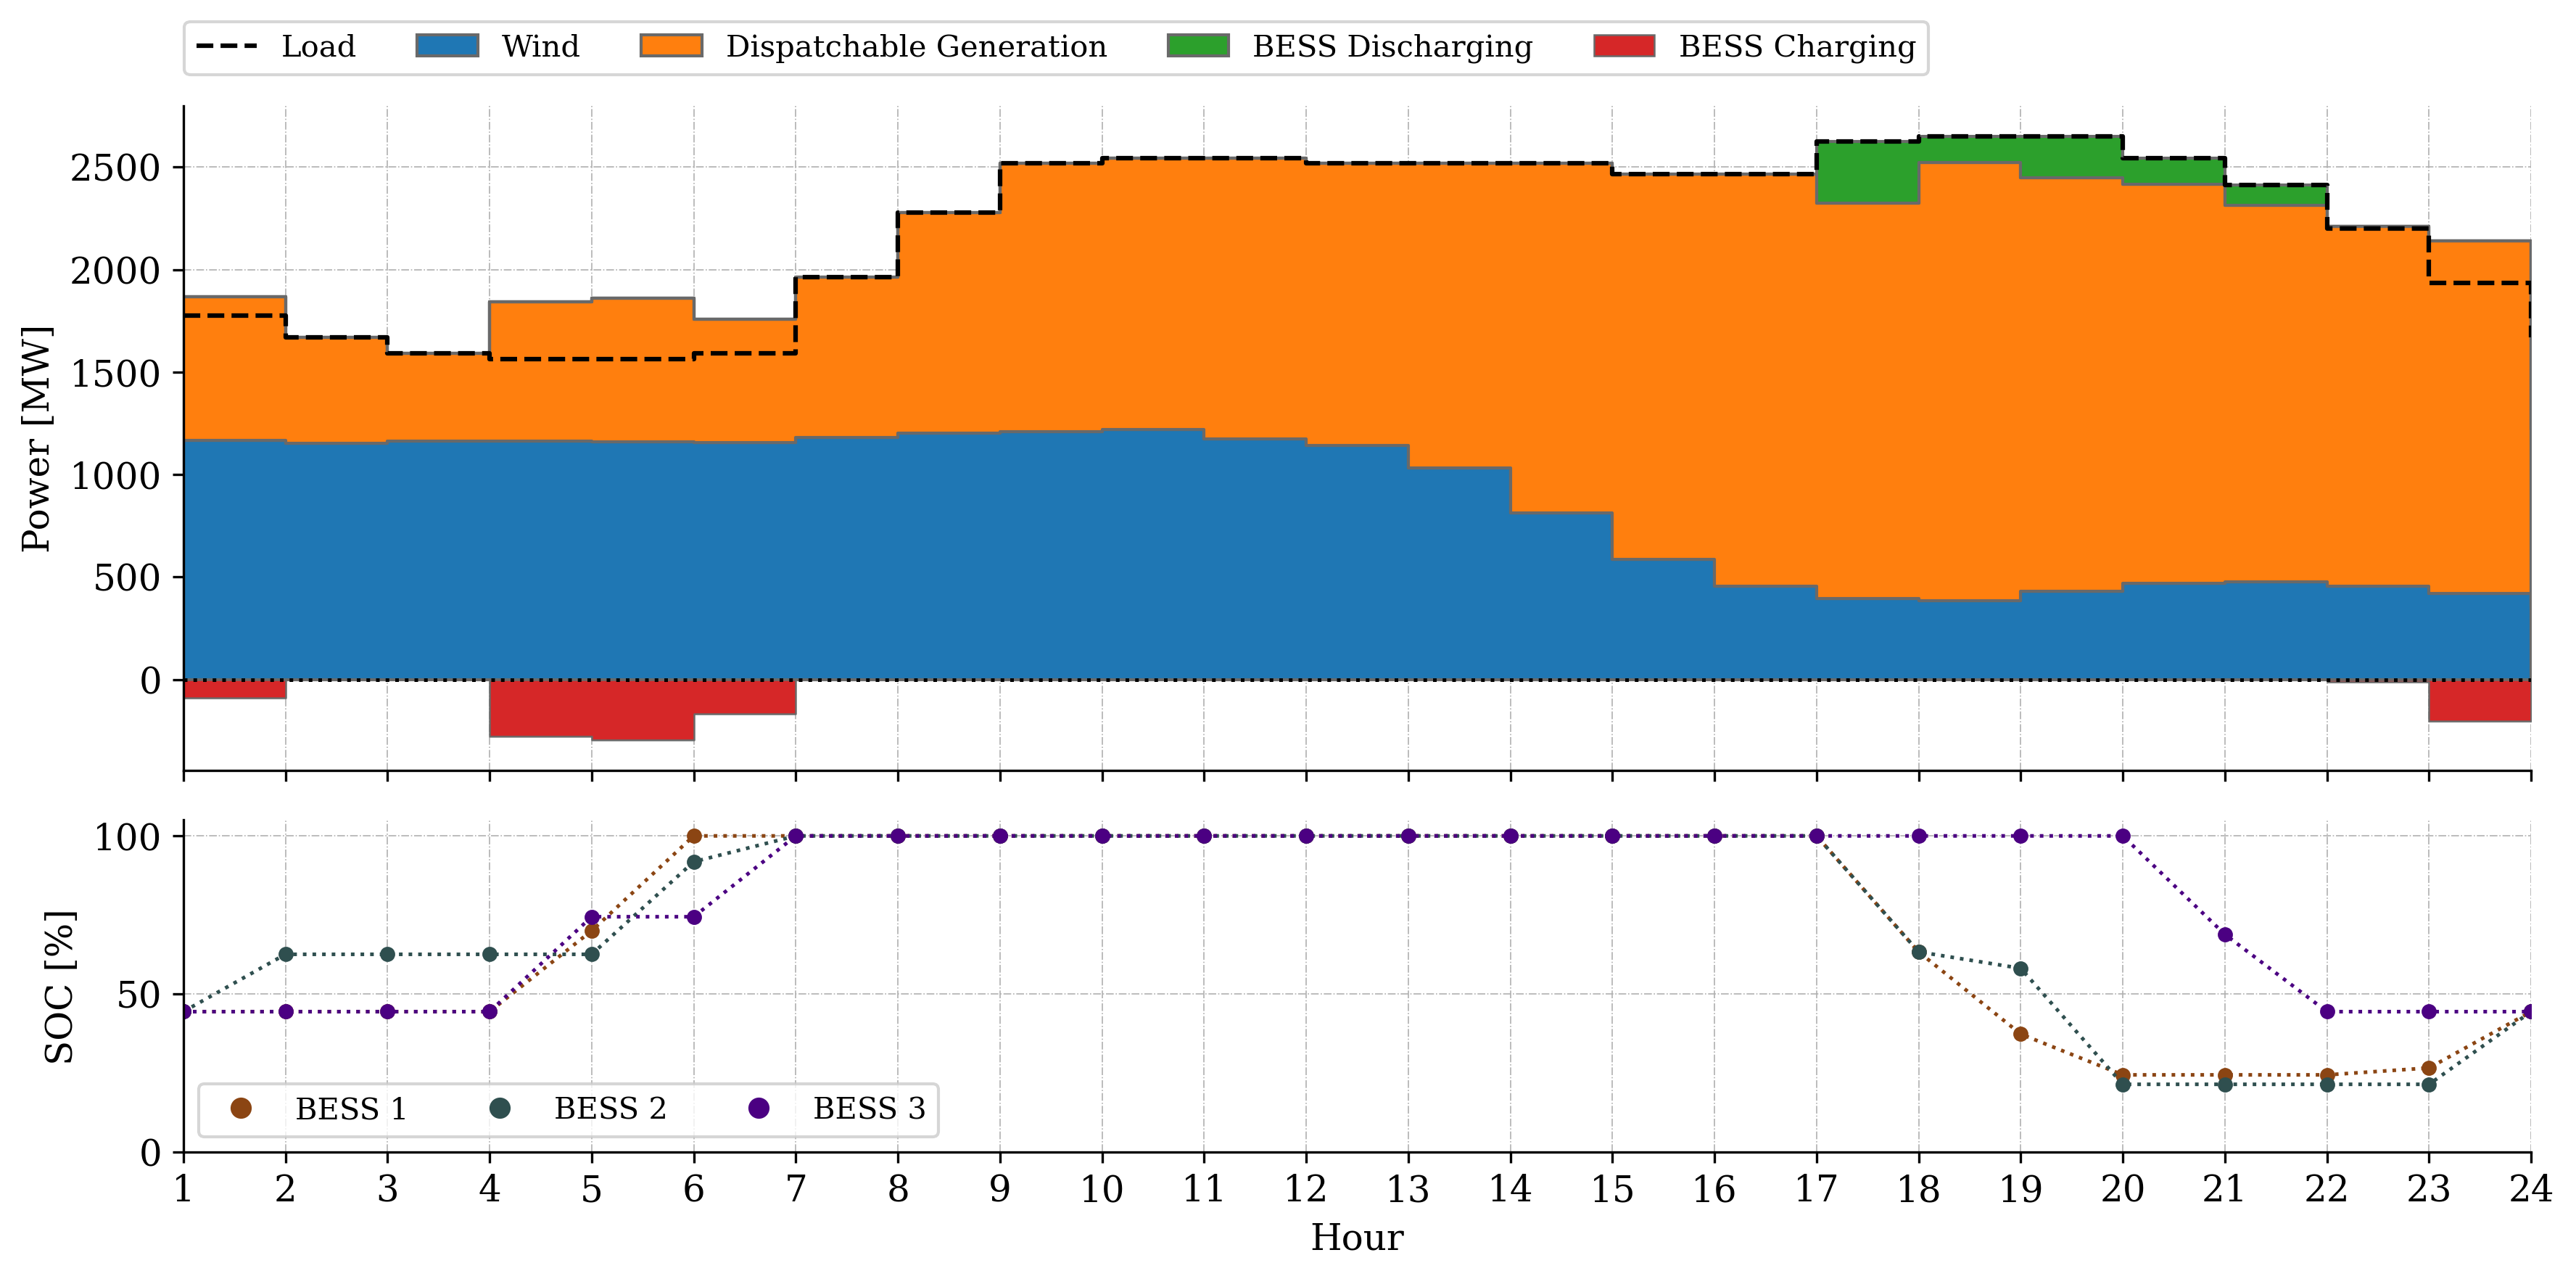

In [16]:
results = solve_mp_multihour(BESS = True, print_variable_results=True, show_plot=True, save_fig=True)

In [ ]:
results_no_bess = solve_mp_multihour(BESS = False, print_variable_results=False, show_plot=False)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3073 rows, 1008 columns and 6769 nonzeros
Model fingerprint: 0x13107400
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [4e+03, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 2203 rows and 264 columns
Presolve time: 0.00s
Presolved: 870 rows, 1253 columns, 3504 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     540    1.7247313e+06   0.000000e+00   0.000000e+00      0s

Solved in 540 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.724731256e+06
-----------------------------------------------
Optimal objective value: 1724731.26 DKK
-------------------------------

Generate plot for generation composition and branch congestion

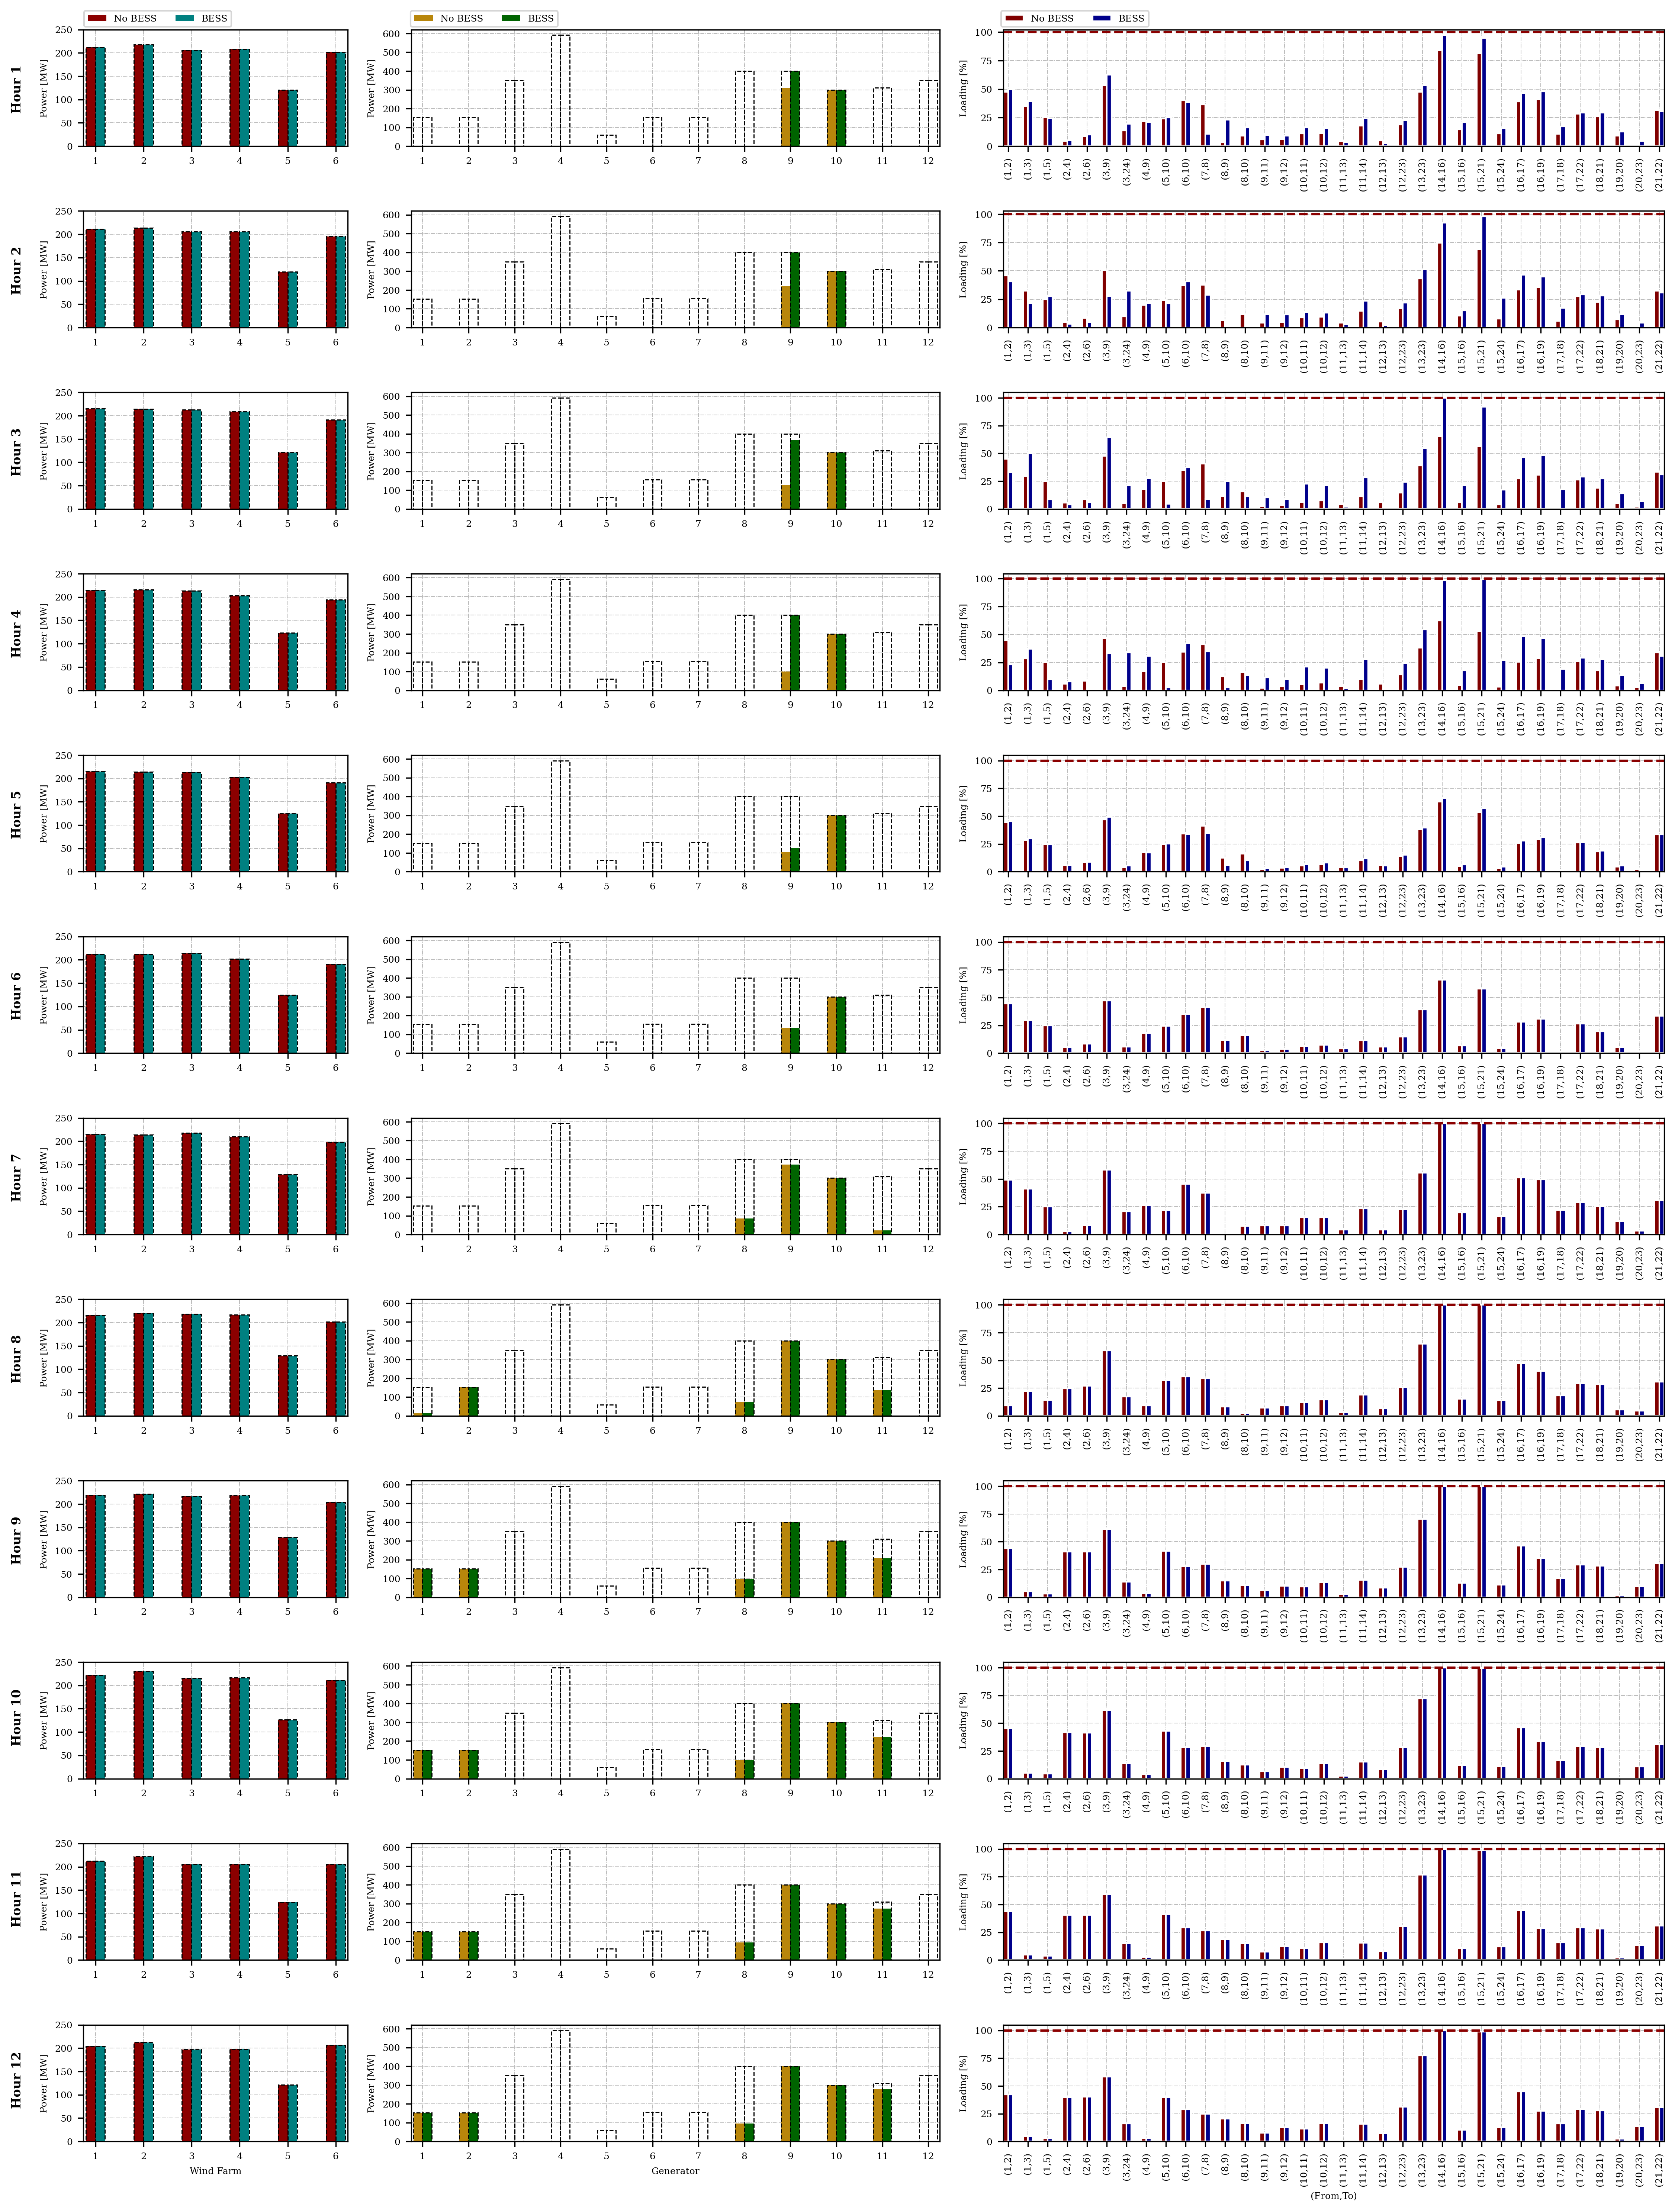

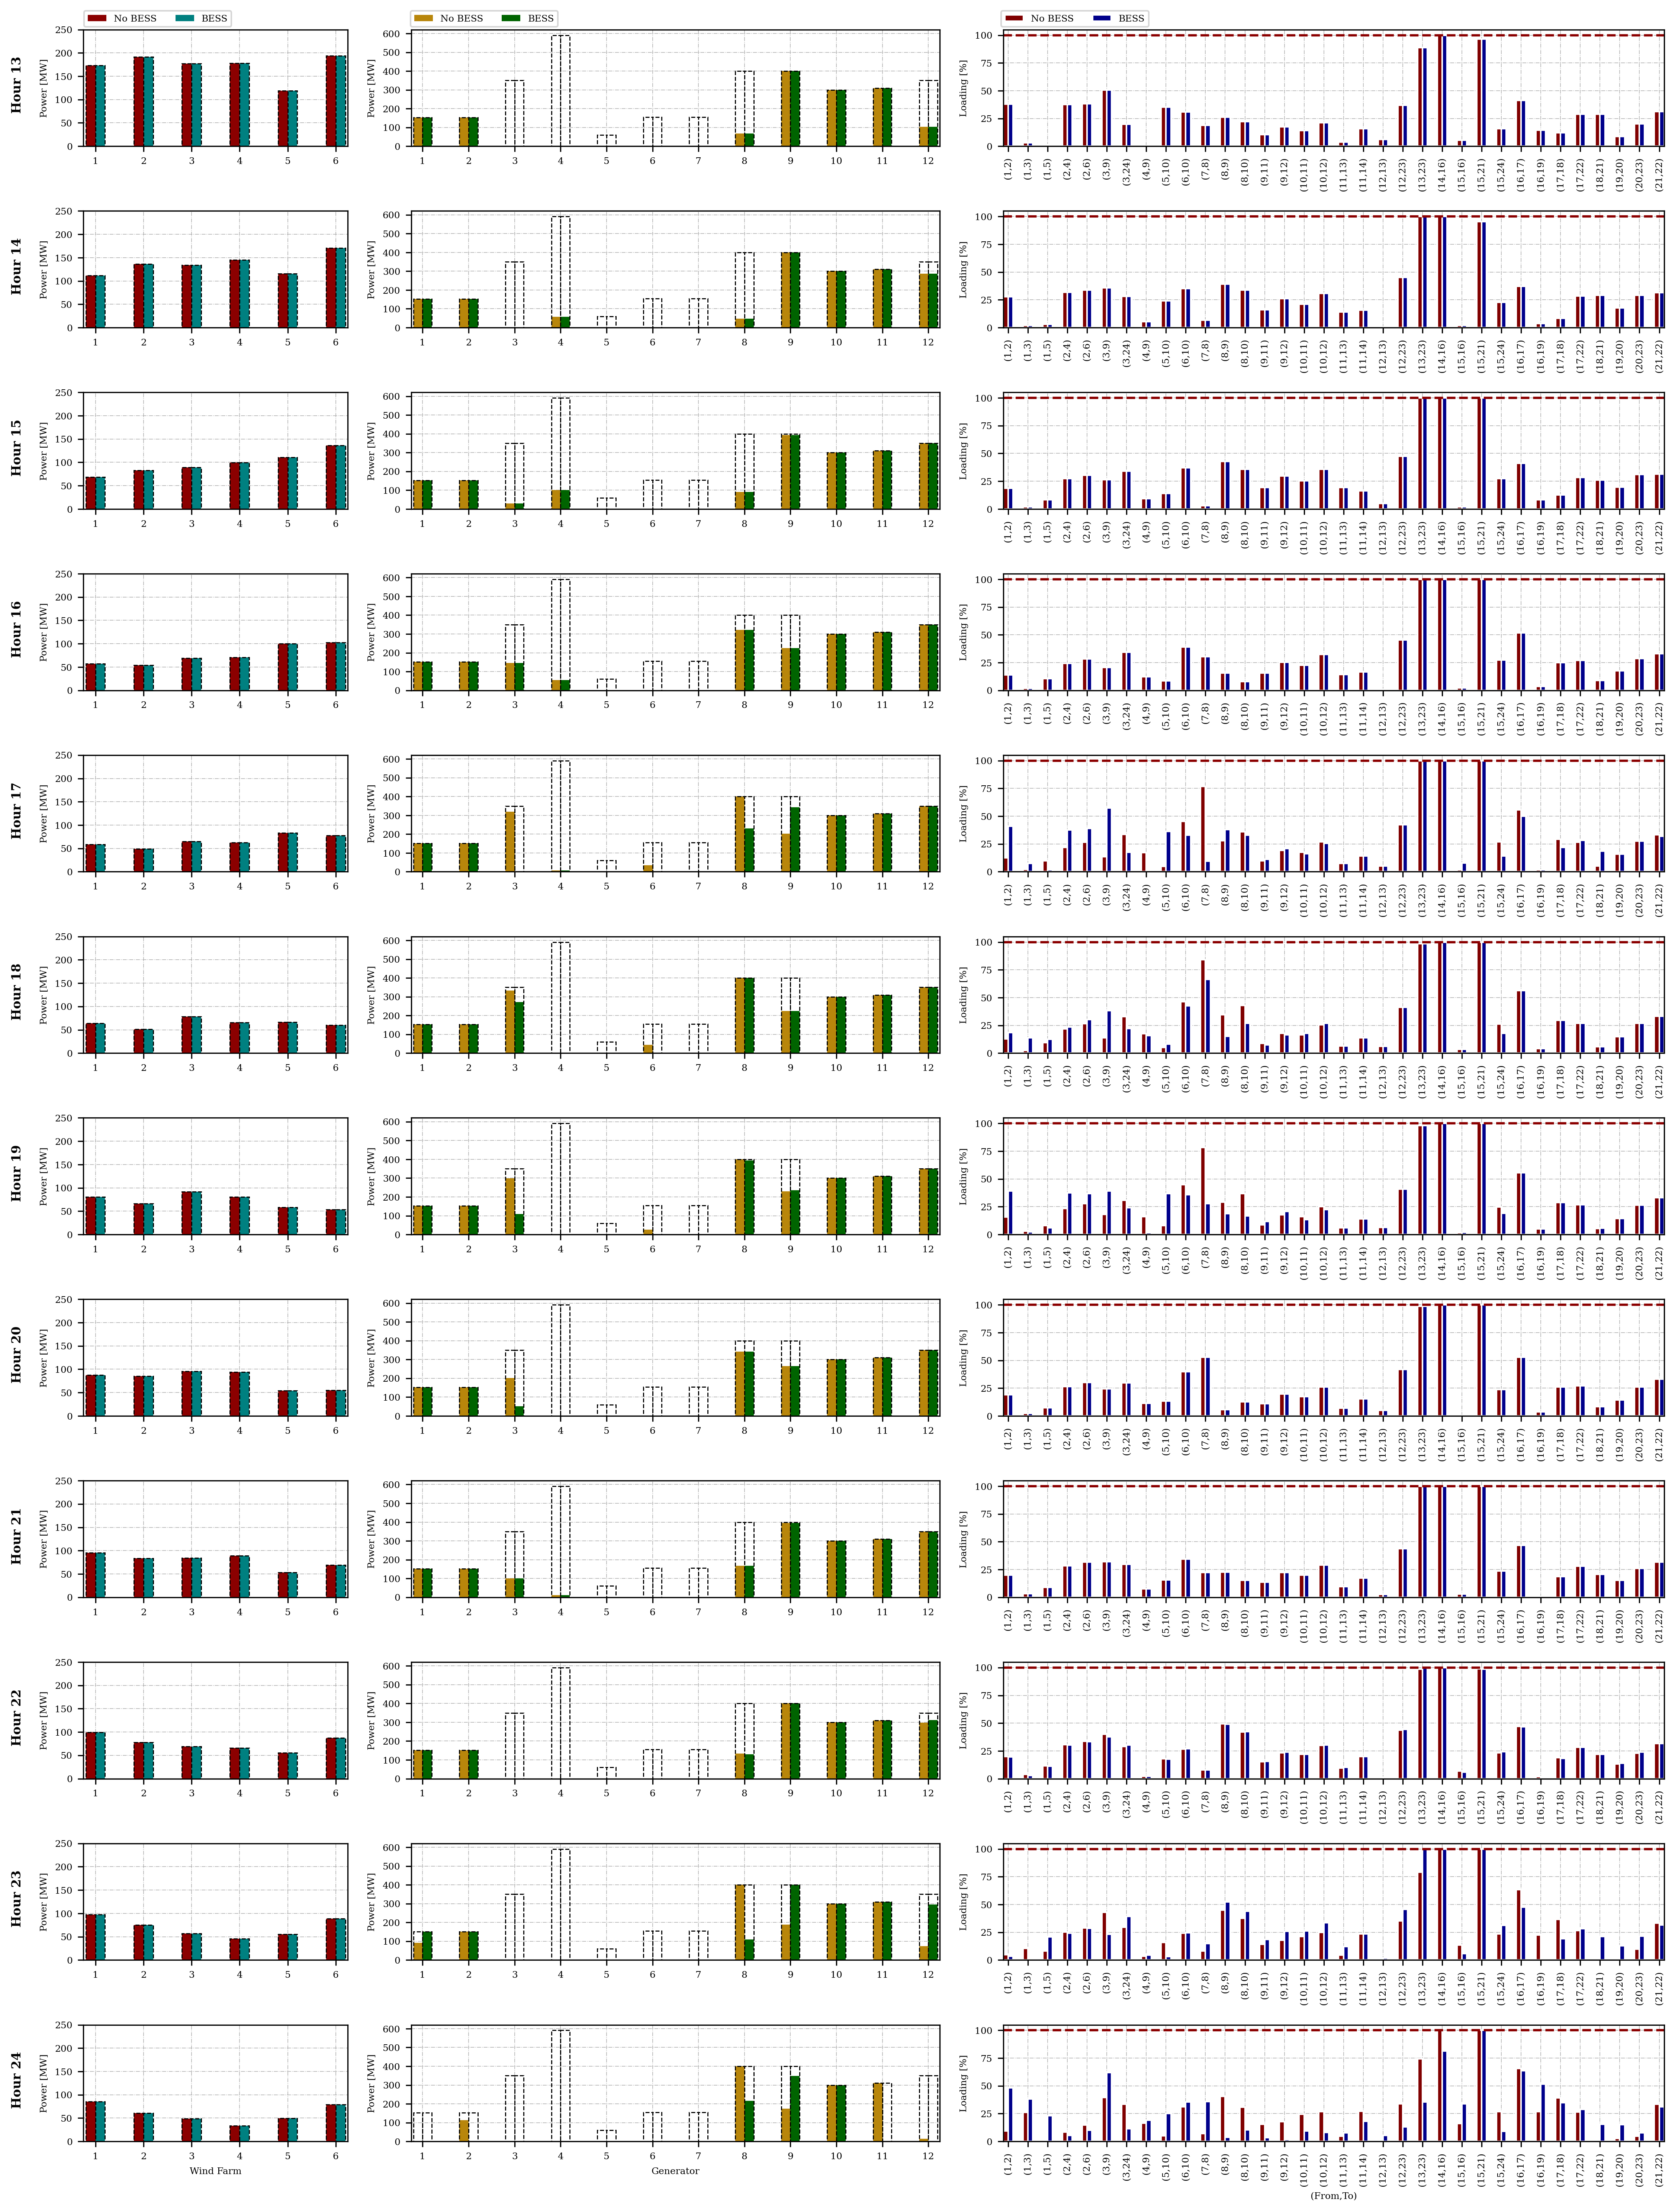

In [ ]:
#First half

fig, ax = plt.subplots(12,3,figsize=( 15 , 20 ) , dpi=300, gridspec_kw={'width_ratios': [1, 2, 2.5]}) # Create the figure
branch_flows = results.get('flows')
flow_labels = []

for row in range(len(branch_flows)):
    label = '(' + str(branch_flows.iloc[row, 0] + 1) + ',' + str(branch_flows.iloc[row, 1] + 1) + ')'
    flow_labels.append(label)

for t in range(12):
    (results_no_bess.get('wind')[t]['p_W'] * S_base_3ph).plot(kind='bar', ax=ax[t][0], color='darkred', width=-0.2, label='No BESS', align = 'edge')
    (wind_data.T[t].reset_index(drop=True)).plot(kind='bar', ax=ax[t][0], color='black', width=-0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')
    (results.get('wind')[t]['p_W'] * S_base_3ph).plot(kind='bar', ax=ax[t][0], color='teal', width=0.2, label='BESS', align = 'edge')
    (wind_data.T[t].reset_index(drop=True)).plot(kind='bar', ax=ax[t][0], color='black', width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')

    ax[t][0].set_ylabel('Power [MW]', fontsize=6)
    ax[-1][0].set_xlabel('Wind Farm', fontsize=6)
    ax[t][0].set_xticks(ticks = np.arange(0, len(wind_data.columns)), labels = np.arange(1, len(wind_data.columns) + 1), fontsize=6, rotation = 0)
    ax[0][0].legend(loc='upper left',bbox_to_anchor=(-0.015, 1.2), ncol=2, fontsize=6)
    ax[t][0].set_ylim([0,250])
    ax[t][0].set_yticks(np.arange(0,250 + 50, 50))
    ax[t][0].set_yticklabels(np.arange(0,250 + 50, 50), fontsize=6)
    ax[t][0].set_xlim([-0.25,5.25])

    #Edge alignment with negative width makes them align with right edge instead of left
    (results_no_bess.get('gen')[t]['p_G'] * S_base_3ph).plot(kind='bar', ax=ax[t][1], color='darkgoldenrod', width=-0.2, label='No BESS', align = 'edge')
    (gen_data['P max MW']).plot(kind='bar', ax=ax[t][1], color='black', width=-0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')
    (results.get('gen')[t]['p_G'] * S_base_3ph).plot(kind='bar', ax=ax[t][1], color='darkgreen', width=0.2, label='BESS', align = 'edge')
    (gen_data['P max MW']).plot(kind='bar', ax=ax[t][1], color='black', width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')


    ax[t][1].set_ylabel('Power [MW]', fontsize=6)
    ax[-1][1].set_xlabel('Generator', fontsize=6)
    ax[t][1].set_xticks(ticks = np.arange(0, len(gen_data)), labels = np.arange(1, len(gen_data) + 1), fontsize=6, rotation = 0)
    ax[t][1].set_yticks(np.arange(0,550 + 100, 100))
    ax[t][1].set_yticklabels(np.arange(0,550 + 100, 100), fontsize=6)
    ax[t][1].set_xlim([-0.25,11.25])
    ax[0][1].legend(loc='upper left',bbox_to_anchor=(-0.01, 1.2), ncol=2, fontsize=6)

    results_no_bess.get('flows')[t]['Loading Percentage'].plot(kind='bar', ax=ax[t][2], color='maroon', width=-0.25, label='No BESS', align='edge', edgecolor='white')
    results.get('flows')[t]['Loading Percentage'].plot(kind='bar', ax=ax[t][2], color='darkblue', width=0.25, label='BESS', align='edge', edgecolor='white')
    ax[t][2].axhline(100, color='darkred', linestyle='--')
    ax[t][2].set_ylabel('Loading [%]', fontsize=6)
    ax[-1][2].set_xlabel('(From,To)', fontsize=6)
    ax[t][2].set_yticks(np.arange(0,100 + 25, 25))
    ax[t][2].set_yticklabels(np.arange(0,100 + 25, 25), fontsize=6)
    ax[t][2].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels, fontsize=6)
    ax[t][2].set_xlim([-0.25,33.25])
    ax[0][2].legend(loc='upper left',bbox_to_anchor=(-0.01, 1.2), ncol=2, fontsize=6)

    ax[t][0].set_title('Hour %d' % (t+1), fontsize=8, weight='bold', rotation='vertical', x=-0.25, y=0.225, horizontalalignment='center')

    for i in range(3):
        ax[t][i].spines[['right', 'top']].set_visible(True)
        ax[t][i].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/multi_timestep_results_loading_congestion_part_1.png',bbox_inches='tight')
plt.savefig('Figures/multi_timestep_results_loading_congestion_part_1.pdf',bbox_inches='tight')
plt.show()

#last half

fig, ax = plt.subplots(12,3,figsize=( 15 , 20 ) , dpi=300, gridspec_kw={'width_ratios': [1, 2, 2.5]}) # Create the figure

flow_labels = []

for row in range(len(branch_flows)):
    label = '(' + str(branch_flows.iloc[row, 0] + 1) + ',' + str(branch_flows.iloc[row, 1] + 1) + ')'
    flow_labels.append(label)

for t in range(12):
    (results_no_bess.get('wind')[t + 12]['p_W'] * S_base_3ph).plot(kind='bar', ax=ax[t][0], color='darkred', width=-0.2, label='No BESS', align = 'edge')
    (wind_data.T[t + 12].reset_index(drop=True)).plot(kind='bar', ax=ax[t][0], color='black', width=-0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')
    (results.get('wind')[t + 12]['p_W'] * S_base_3ph).plot(kind='bar', ax=ax[t][0], color='teal', width=0.2, label='BESS', align = 'edge')
    (wind_data.T[t + 12].reset_index(drop=True)).plot(kind='bar', ax=ax[t][0], color='black', width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')

    ax[t][0].set_ylabel('Power [MW]', fontsize=6)
    ax[-1][0].set_xlabel('Wind Farm', fontsize=6)
    ax[t][0].set_xticks(ticks = np.arange(0, len(wind_data.columns)), labels = np.arange(1, len(wind_data.columns) + 1), fontsize=6, rotation = 0)
    ax[0][0].legend(loc='upper left',bbox_to_anchor=(-0.015, 1.2), ncol=2, fontsize=6)
    ax[t][0].set_ylim([0,250])
    ax[t][0].set_yticks(np.arange(0,250 + 50, 50))
    ax[t][0].set_yticklabels(np.arange(0,250 + 50, 50), fontsize=6)
    ax[t][0].set_xlim([-0.25,5.25])

    #Edge alignment with negative width makes them align with right edge instead of left
    (results_no_bess.get('gen')[t + 12]['p_G'] * S_base_3ph).plot(kind='bar', ax=ax[t][1], color='darkgoldenrod', width=-0.2, label='No BESS', align = 'edge')
    (gen_data['P max MW']).plot(kind='bar', ax=ax[t][1], color='black', width=-0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')
    (results.get('gen')[t + 12]['p_G'] * S_base_3ph).plot(kind='bar', ax=ax[t][1], color='darkgreen', width=0.2, label='BESS', align = 'edge')
    (gen_data['P max MW']).plot(kind='bar', ax=ax[t][1], color='black', width=0.2, edgecolor='black', linestyle='--', fill=False, linewidth=0.7, align = 'edge', label='_nolegend_')


    ax[t][1].set_ylabel('Power [MW]', fontsize=6)
    ax[-1][1].set_xlabel('Generator', fontsize=6)
    ax[t][1].set_xticks(ticks = np.arange(0, len(gen_data)), labels = np.arange(1, len(gen_data) + 1), fontsize=6, rotation = 0)
    ax[t][1].set_yticks(np.arange(0,550 + 100, 100))
    ax[t][1].set_yticklabels(np.arange(0,550 + 100, 100), fontsize=6)
    ax[t][1].set_xlim([-0.25,11.25])
    ax[0][1].legend(loc='upper left',bbox_to_anchor=(-0.01, 1.2), ncol=2, fontsize=6)

    results_no_bess.get('flows')[t + 12]['Loading Percentage'].plot(kind='bar', ax=ax[t][2], color='maroon', width=-0.25, label='No BESS', align='edge', edgecolor='white')
    results.get('flows')[t + 12]['Loading Percentage'].plot(kind='bar', ax=ax[t][2], color='darkblue', width=0.25, label='BESS', align='edge', edgecolor='white')
    ax[t][2].axhline(100, color='darkred', linestyle='--')
    ax[t][2].set_ylabel('Loading [%]', fontsize=6)
    ax[-1][2].set_xlabel('(From,To)', fontsize=6)
    ax[t][2].set_yticks(np.arange(0,100 + 25, 25))
    ax[t][2].set_yticklabels(np.arange(0,100 + 25, 25), fontsize=6)
    ax[t][2].set_xticks(ticks = np.arange(0, len(flow_labels), 1), labels = flow_labels, fontsize=6)
    ax[t][2].set_xlim([-0.25,33.25])
    ax[0][2].legend(loc='upper left',bbox_to_anchor=(-0.01, 1.2), ncol=2, fontsize=6)

    ax[t][0].set_title('Hour %d' % (t + 1 + 12), fontsize=8, weight='bold', rotation='vertical', x=-0.25, y=0.225, horizontalalignment='center')

    for i in range(3):
        ax[t][i].spines[['right', 'top']].set_visible(True)
        ax[t][i].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
#plt.savefig('Figures/multi_timestep_results_loading_congestion_part_2.png',bbox_inches='tight')
#plt.savefig('Figures/multi_timestep_results_loading_congestion_part_2.pdf',bbox_inches='tight')
plt.show()
